# Predicting TCS stock price using ARIMA model

By Aditya Laxmikant Kelkar

In this notebook , we will take TCS's closing price on daily basis and try to predict next day's closing price with the help of ARIMA i.e. AutoRegressive Integrated Moving Averages model .

Importing necessary libraries ...

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = "retina"

Downloaded data from YahooFinance into CSV file .

Then we will import the CSV file and 
set the date column as index to make it a time series .

In [2]:
tcs_data = pd.read_csv('TCS_NSE_Daily_20Years.csv')
tcs_data['Date'] = pd.to_datetime(tcs_data['Date'])
tcs_data.sort_values('Date',inplace=True)
tcs_data.set_index('Date',inplace=True)

tcs_data.shape

(4876, 6)

In [3]:
tcs_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-10,37.250000,37.750000,36.125000,36.762501,27.234730,240192.0
2002-01-11,37.525002,38.150002,36.762501,36.962502,27.382895,108792.0
2002-02-09,44.750000,45.974998,44.049999,44.500000,32.966904,2389568.0
2002-02-10,36.762501,36.762501,36.762501,36.762501,27.234730,0.0
2002-02-12,44.875000,49.000000,44.474998,47.387501,35.106060,1388680.0


# Preparing the data to use for ARIMA model

We will first calculate daily returns .

In [4]:
tcs_data['daily_returns'] = np.log(tcs_data['Close']).diff()
tcs_data.head()

,Open,High,Low,Close,Adj Close,Volume,daily_returns
Date,,,,,,,
2002-01-10,37.250000,37.750000,36.125000,36.762501,27.234730,240192.0,NaN
2002-01-11,37.525002,38.150002,36.762501,36.962502,27.382895,108792.0,0.005426
2002-02-09,44.750000,45.974998,44.049999,44.500000,32.966904,2389568.0,0.185585
2002-02-10,36.762501,36.762501,36.762501,36.762501,27.234730,0.0,-0.191011
2002-02-12,44.875000,49.000000,44.474998,47.387501,35.106060,1388680.0,0.253880


In [5]:
tcs_data.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

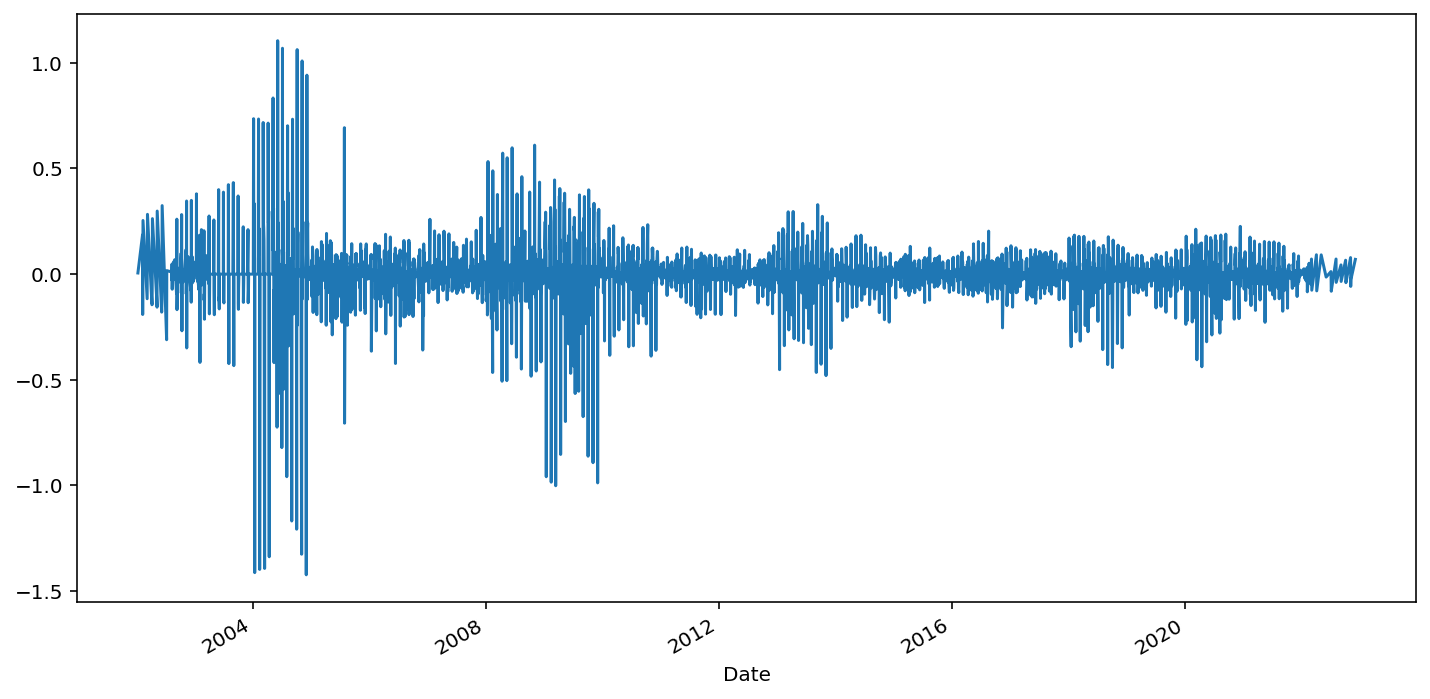

In [6]:
tcs_data.daily_returns.plot(kind='line',figsize=(12,6))

In [7]:
daily_returns = tcs_data.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1)
daily_returns.head()

,daily_returns
Date,
2002-01-11,0.005426
2002-02-09,0.185585
2002-02-10,-0.191011
2002-02-12,0.253880
2002-03-09,-0.110915


# We will run Dickey-Fuller Test to check for Stationarity of Data

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [9]:
rolling_mean = daily_returns.rolling(20).mean()
rolling_sd = daily_returns.rolling(20).std()

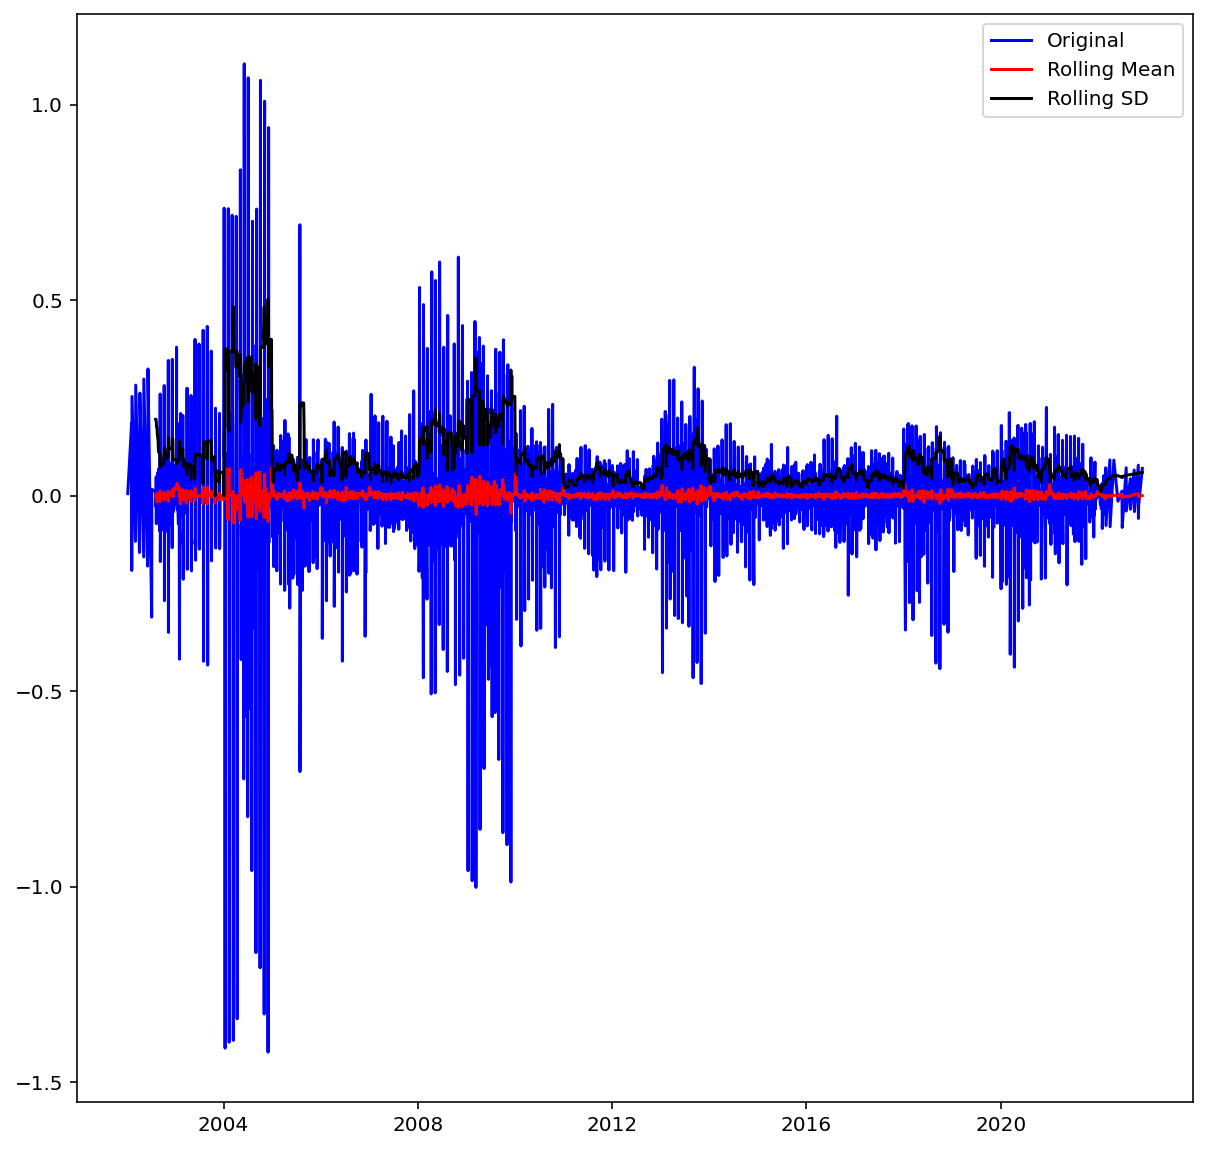

In [10]:
plt.figure(figsize=(10,10))
original_data = plt.plot(daily_returns,color='blue',label='Original')
rmean = plt.plot(rolling_mean,color='red',label='Rolling Mean')
rstd = plt.plot(rolling_sd,color='black',label='Rolling SD')
plt.legend(loc='best')
plt.show(block=False)

Now we will perform Dickey-Fuller Test

In [11]:
df_test = sm.tsa.adfuller(daily_returns.daily_returns,autolag='AIC')
dfoutput = pd.Series(df_test[0:4],index=['Test Statistics','p-value','#Lags Used','No of Observations used'])
for key,value in df_test[4].items():
    dfoutput['Critical value ({0})'.format(key)]=value
    
dfoutput

Test Statistics           -1.740754e+01
p-value                    4.906963e-30
#Lags Used                 2.800000e+01
No of Observations used    4.827000e+03
Critical value (1%)       -3.431705e+00
Critical value (5%)       -2.862139e+00
Critical value (10%)      -2.567089e+00
dtype: float64

The p-value is <0.05 so we reject the null hypothesis . 

Conclusion : The data is stationary

# ACF and PACF

ACF gives us pictorial representation of how much current Y value i.e. Today's Stock Price is correlated to previous n Y values.

PACF gives value of correlation between two Y values separated by 'n' lags excluding impact of Y values between them .

These charts help us to set the hyperparameters of the model .

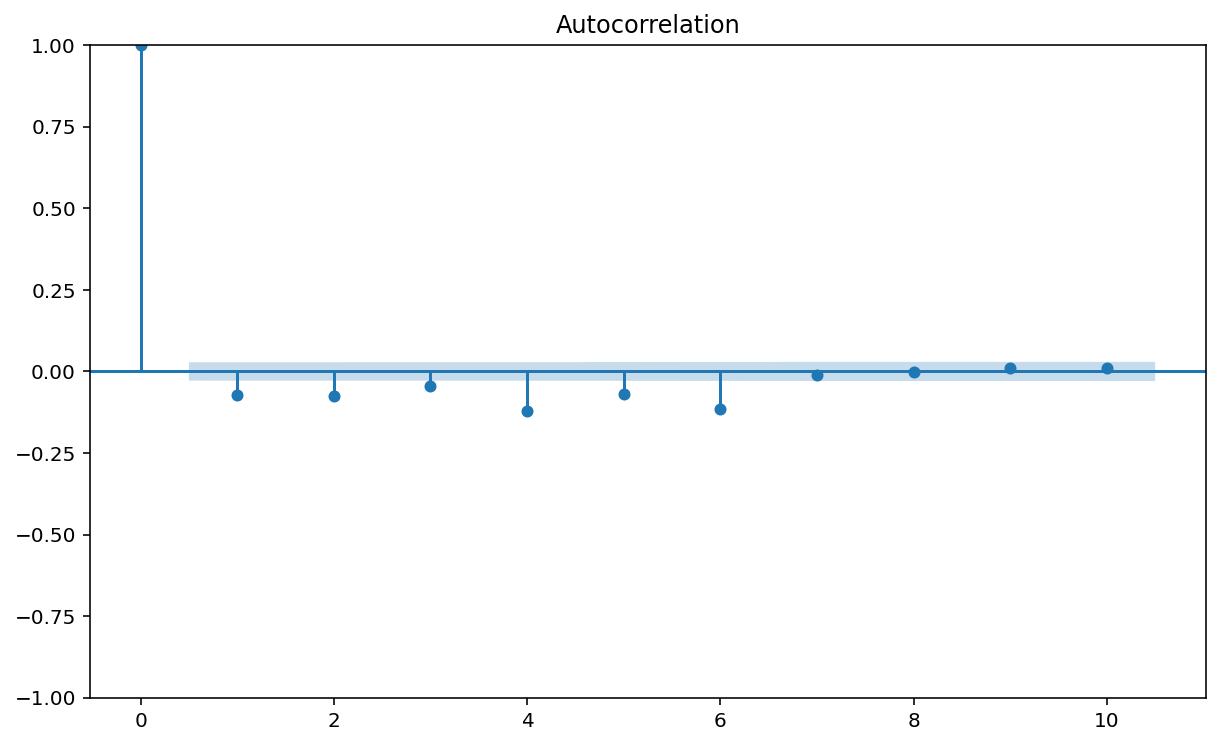

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

fig , auto_x = plt.subplots(figsize=(10,6))
plot_acf(daily_returns.values,lags=10,ax=auto_x)
plt.show()

From above diagram it is clear that current Y value is highly correlated with 1 prior value of Y .

c:\users\laxmikanth\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


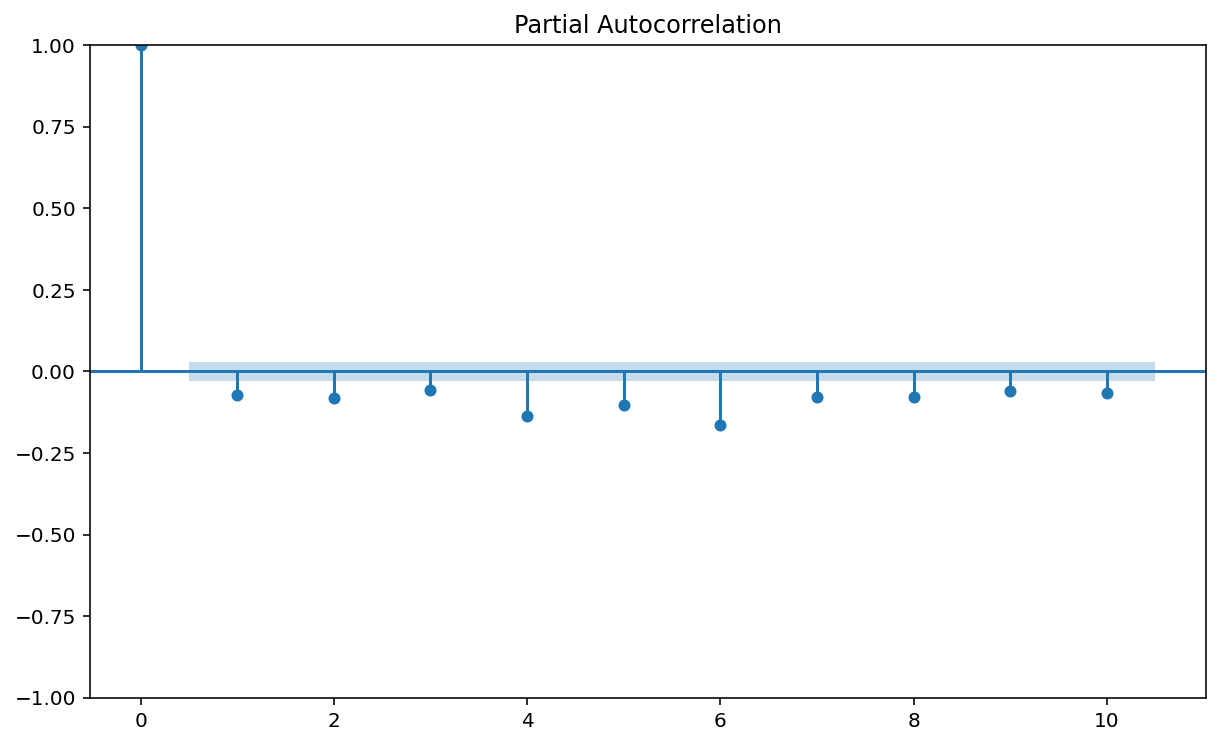

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

fig , auto_x = plt.subplots(figsize=(10,6))
plot_pacf(daily_returns.values,lags=10,ax=auto_x)
plt.show()

.

# Building the ARIMA model

In [14]:
from statsmodels.tsa.arima.model import ARIMA

arima_model_test = ARIMA(daily_returns.values,order=(1,7,1)).fit()
arima_model_test.summary()

c:\users\laxmikanth\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4856
Model:                 ARIMA(1, 7, 1)   Log Likelihood              -10164.139
Date:                Sun, 27 Mar 2022   AIC                          20334.277
Time:                        20:09:44   BIC                          20353.737
Sample:                             0   HQIC                         20341.108
                               - 4856                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8452      0.003   -276.233      0.000      -0.851      -0.839
ma.L1         -0.9994      0.031    -32.166      0.000      -1.060      -0.939
sigma2         3.8678      0.123     31.528      0.000       3.627       4.108
===================================================================================
Ljung-Box (L1) (Q):                2036.23   Jarque-Bera (JB):             57121.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
arima_model_test_2 = ARIMA(daily_returns.values,order=(3,1,1)).fit()
arima_model_test_2.summary()

c:\users\laxmikanth\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\laxmikanth\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\laxmikanth\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4856
Model:                 ARIMA(3, 1, 1)   Log Likelihood                3518.711
Date:                Sun, 27 Mar 2022   AIC                          -7027.421
Time:                        20:24:17   BIC                          -6994.983
Sample:                             0   HQIC                         -7016.035
                               - 4856                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0824      0.011     -7.167      0.000      -0.105      -0.060
ar.L2         -0.0840      0.006    -13.340      0.000      -0.096      -0.072
ar.L3         -0.0553      0.008     -6.551      0.000      -0.072      -0.039
ma.L1         -1.0000      0.088    -11.396      0.000      -1.172      -0.828
sigma2         0.0137      0.001     11.462      0.000       0.011       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):            382627.71
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -2.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
arima_model_test_3 = ARIMA(daily_returns.values,order=(3,7,1)).fit()
arima_model_test_3.summary()

c:\users\laxmikanth\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4856
Model:                 ARIMA(3, 7, 1)   Log Likelihood               -6643.533
Date:                Sun, 27 Mar 2022   AIC                          13297.066
Time:                        20:10:03   BIC                          13329.499
Sample:                             0   HQIC                         13308.451
                               - 4856                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9981      0.005   -405.171      0.000      -2.008      -1.988
ar.L2         -1.7442      0.008   -207.844      0.000      -1.761      -1.728
ar.L3         -0.6495      0.005   -121.999      0.000      -0.660      -0.639
ma.L1         -0.9997      0.058    -17.126      0.000      -1.114      -0.885
sigma2         0.9041      0.053     17.217      0.000       0.801       1.007
===================================================================================
Ljung-Box (L1) (Q):                 763.31   Jarque-Bera (JB):             60580.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

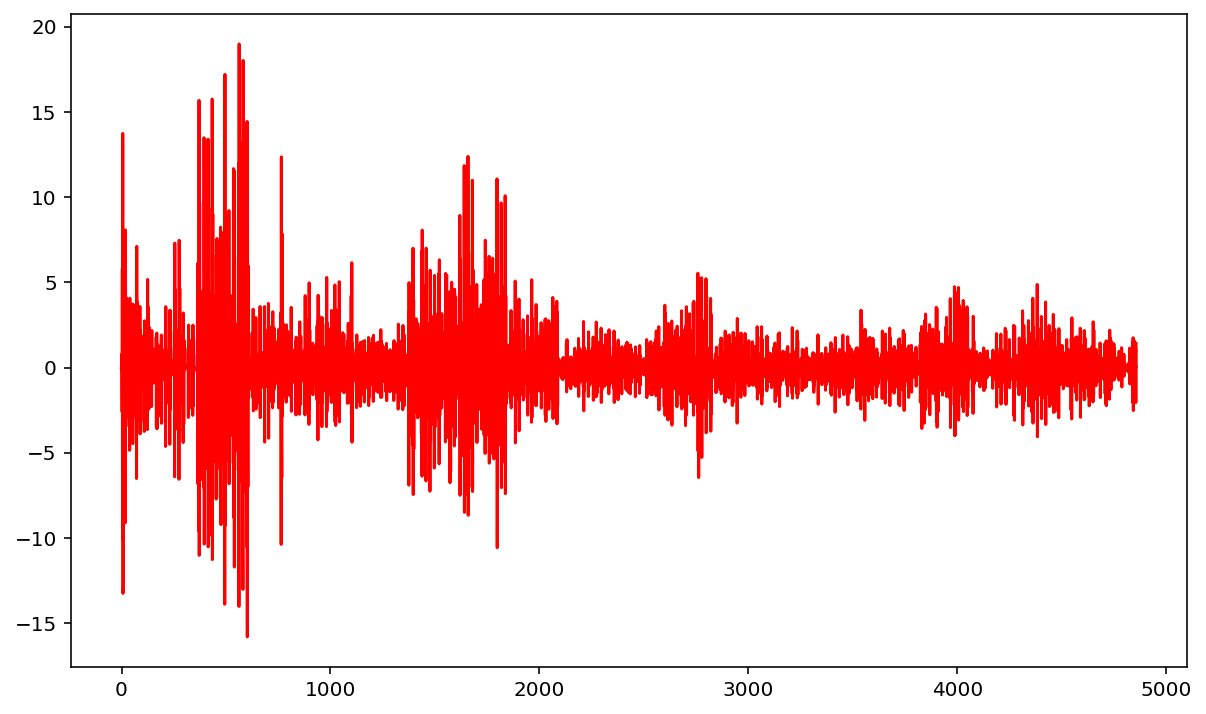

In [17]:
plt.figure(figsize=(10,6))
plt.plot(daily_returns.values,color='blue')
predictions = arima_model_test.fittedvalues
plt.plot(predictions,color='red')
plt.show()

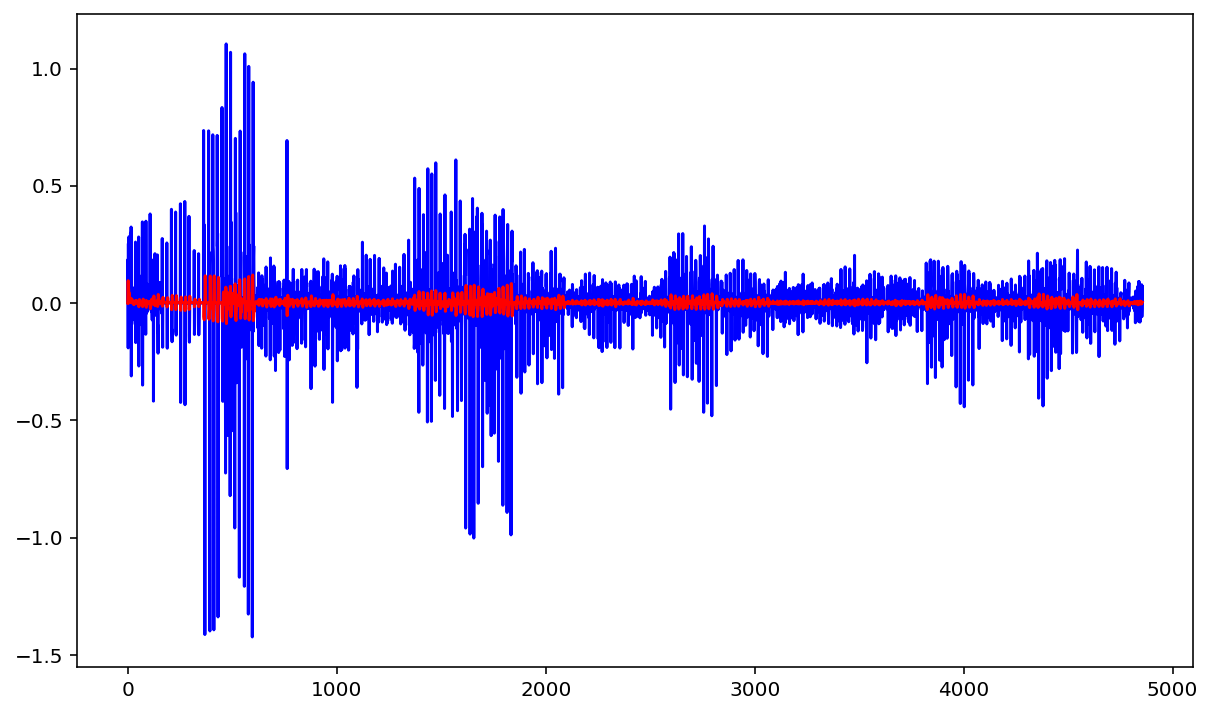

In [43]:
plt.figure(figsize=(10,6))
plt.plot(daily_returns.values,color='blue')
predictions = arima_model_test_2.fittedvalues
plt.plot(predictions,color='red')
plt.show()

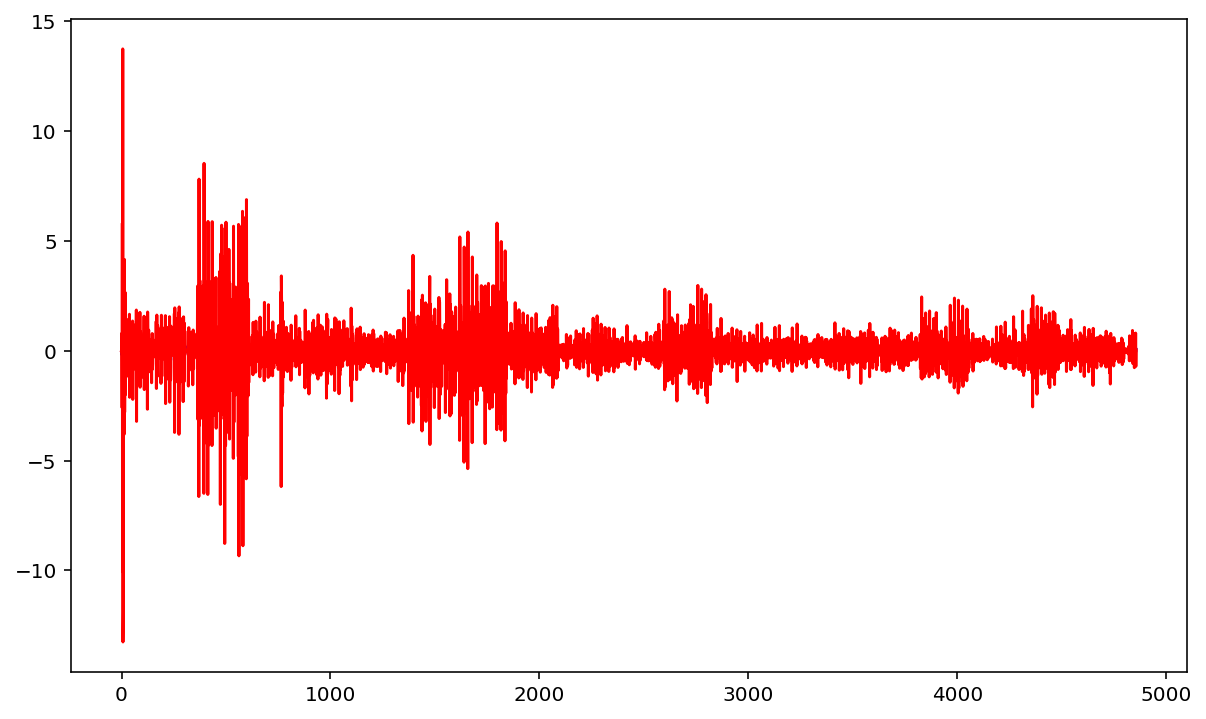

In [19]:
plt.figure(figsize=(10,6))
plt.plot(daily_returns.values,color='blue')
predictions = arima_model_test_3.fittedvalues
plt.plot(predictions,color='red')
plt.show()

Lets predict values 2 days/weeks ahead using 3 models that we have fit .

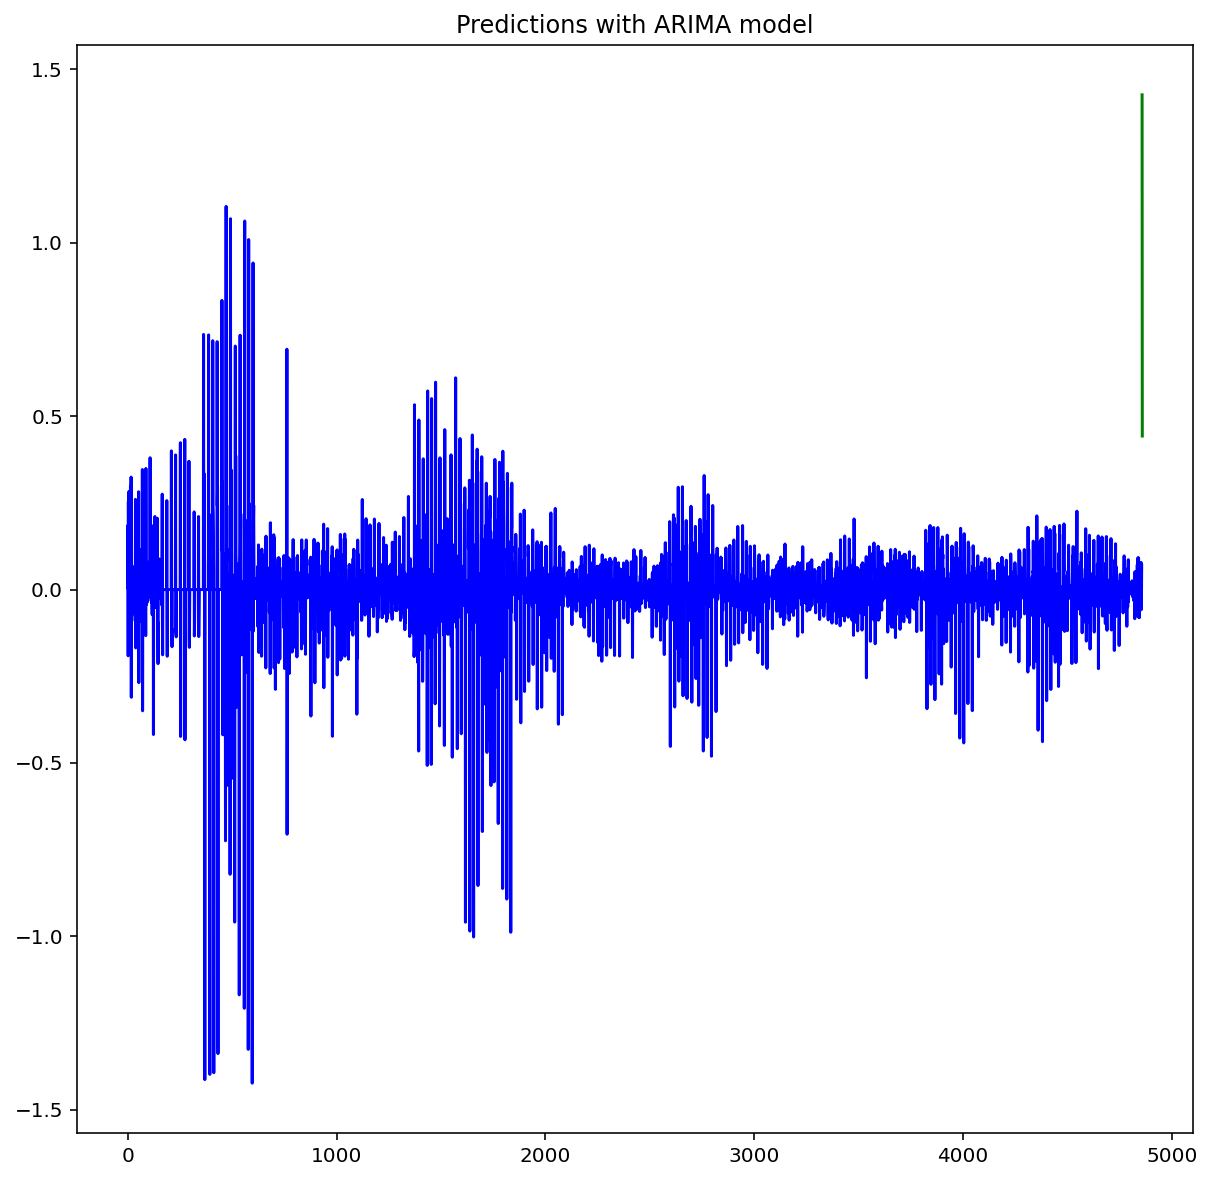

          0
0  1.426577
1  0.442722


In [20]:
steps = 2

forecasted_values = arima_model_test.forecast(steps=steps)

plt.figure(figsize=(10,10))
plt.plot(daily_returns.values,color='blue')

predictions_1 = arima_model_test.fittedvalues
#plt.plot(predictions_1,color='red')

plt.plot(pd.DataFrame(np.array([predictions_1[-1],forecasted_values[0]]).T,index=range(len(daily_returns.values)+1,len(daily_returns.values)+3)),color='green')
plt.title('Predictions with ARIMA model')
plt.show()

print(pd.DataFrame(np.array([predictions_1[-1],forecasted_values[0]])))

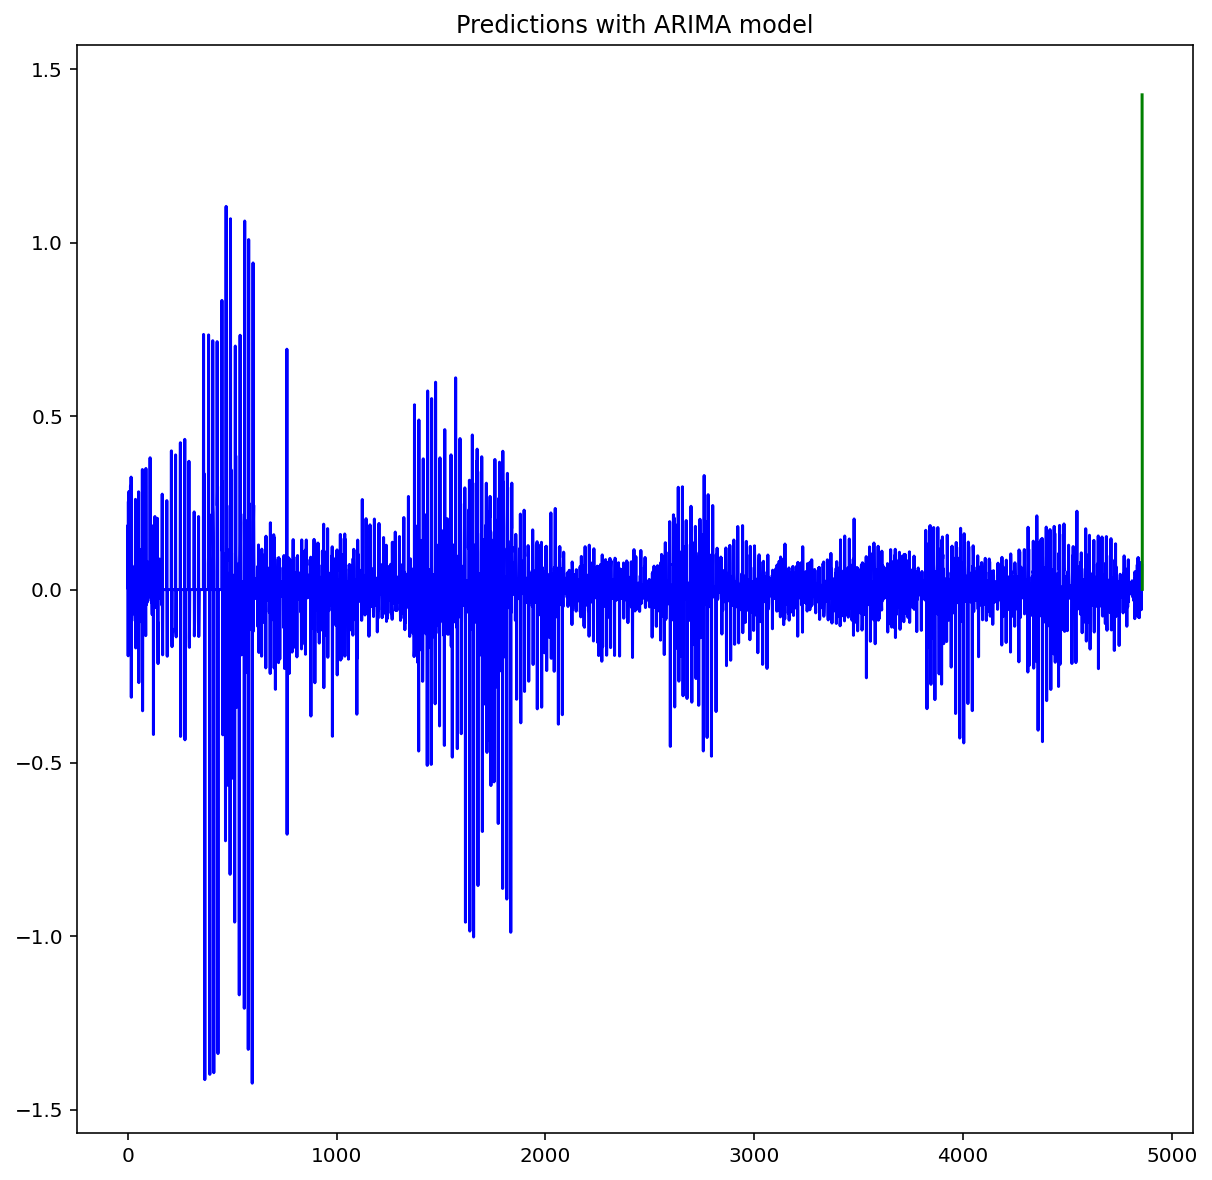

          0
0  1.426577
1  0.000556


In [21]:
steps = 2

forecasted_values = arima_model_test_2.forecast(steps=steps)

plt.figure(figsize=(10,10))
plt.plot(daily_returns.values,color='blue')

predictions_1 = arima_model_test.fittedvalues
#plt.plot(predictions_1,color='red')

plt.plot(pd.DataFrame(np.array([predictions_1[-1],forecasted_values[0]]).T,index=range(len(daily_returns.values)+1,len(daily_returns.values)+3)),color='green')
plt.title('Predictions with ARIMA model')
plt.show()

print(pd.DataFrame(np.array([predictions_1[-1],forecasted_values[0]])))

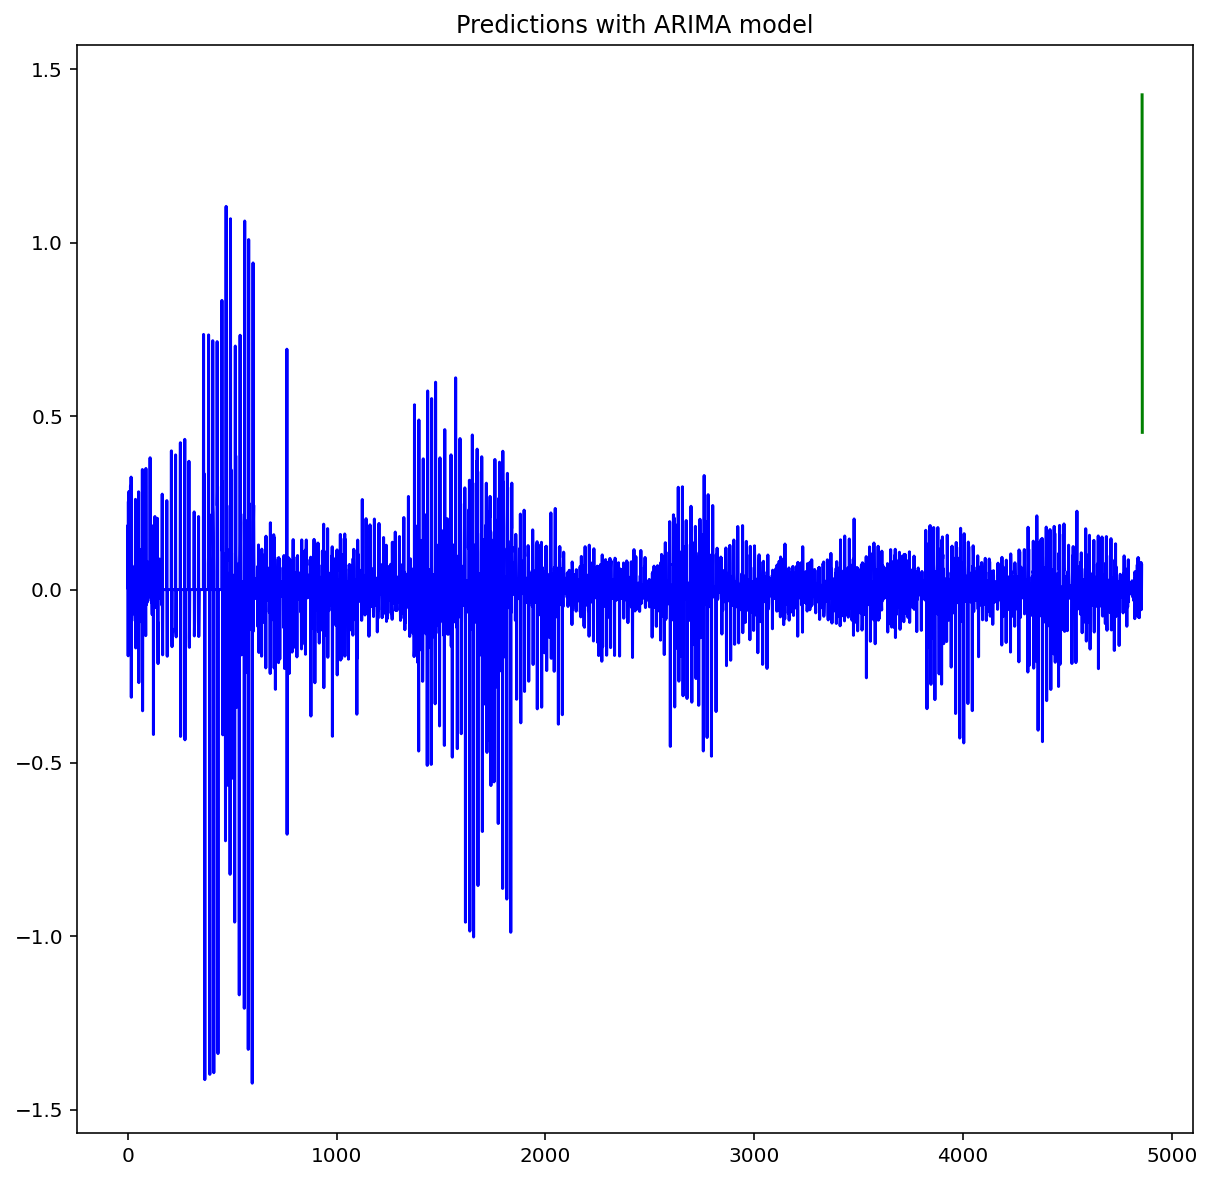

          0
0  1.426577
1  0.453360


In [22]:
steps = 2

forecasted_values = arima_model_test_3.forecast(steps=steps)

plt.figure(figsize=(10,10))
plt.plot(daily_returns.values,color='blue')

predictions_1 = arima_model_test.fittedvalues
#plt.plot(predictions_1,color='red')

plt.plot(pd.DataFrame(np.array([predictions_1[-1],forecasted_values[0]]).T,index=range(len(daily_returns.values)+1,len(daily_returns.values)+3)),color='green')
plt.title('Predictions with ARIMA model')
plt.show()

print(pd.DataFrame(np.array([predictions_1[-1],forecasted_values[0]])))

Calculating next day price...

In [36]:
latest_price = tcs_data.iloc[-1].tolist()
latest_close = latest_price[3]
latest_close

3859.899902

In [41]:
forecasted_price = np.exp(predictions_1[-1])
forecasted_price = forecasted_price + latest_price[6]
forecasted_price = latest_close + forecasted_price
forecasted_price

3864.1342650640245